In [1]:
# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import crossMask, checkImageType, rectMask, mergeMasks
from pepe.simulate import genSyntheticResponse
from pepe.analysis import initialForceSolve
from pepe.tracking import g2HoughCircle

import numpy as np

import cv2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140

# For timing
import time

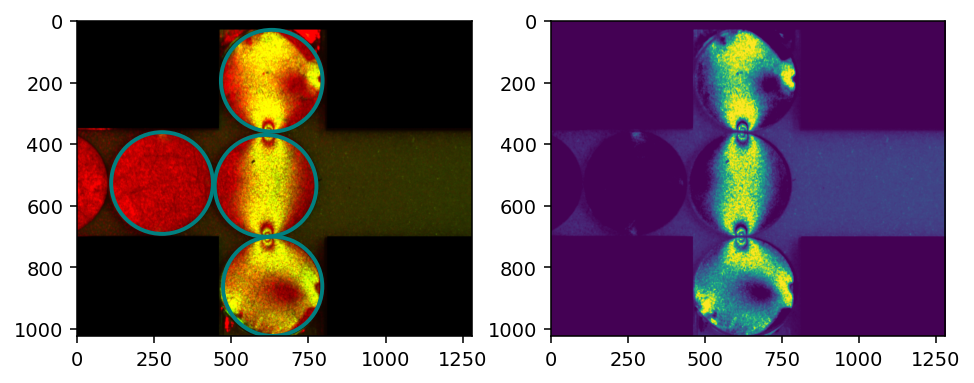

In [16]:
# Make some fake data with several potential wall contacts
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

image = checkImageType('test_data/Mid_Saturation.bmp')
#photoelasticChannel = cv2.blur(image[:,:,1], (30,30))
# g2 to force conversion is calibrated on the scale [0, 1], not [0, 255]
# We also blur the images a little, since they are visibly grainy
photoelasticChannel = cv2.blur(image[:,:,1].astype(np.float64) / 255, (3,3))

centers, radii = g2HoughCircle(image[:,:,0], [160, 180], accumulatorThreshold=30, cannyEdgeThreshold=80)

centers = centers.astype(np.int64)
radii = radii.astype(np.int64)
# Make them all odd
radii += (radii % 2) == 0

# A particle is about 1cm across
pxPerMeter = int(2*np.mean(radii) / .01)
# No idea what the actual value for this is
fSigma = 100

# Create a cross-shaped channel, with some parts on the ends
maskArr = crossMask(image.shape, xlim=np.array([460, 810]), ylim=np.array([350, 700]))

listOfMasks = np.array([maskArr,
                       rectMask(image.shape, corner=np.array([0,400]), dimensions=np.array([30, 500]))])
maskArr = mergeMasks(listOfMasks, signs=np.array([1,-1], dtype=np.int16))


ax[0].imshow(image * maskArr)
for i in range(len(centers)):
    c = plt.Circle(centers[i][::-1], radii[i], label='Detected particles', color='teal', fill=False, linewidth=2)
    ax[0].add_artist(c)

ax[1].imshow(photoelasticChannel * maskArr[:,:,0])
plt.show()

In [17]:
# Parameters of our force solving method
contactPadding = 20
g2MaskPadding = 1
contactMaskRadius = 30
#pxPerMeter = 10000
brightfield = False

forceGuessArr, alphaGuessArr, betaGuessArr = initialForceSolve(photoelasticChannel,
                                                centers, radii, fSigma, pxPerMeter,
                                                contactPadding, g2MaskPadding,
                                                contactMaskRadius=contactMaskRadius,
                                                boundaryMask=maskArr, ignoreBoundary=False)

#forceGuessArr /= np.max([np.max(f) for f in forceGuessArr])

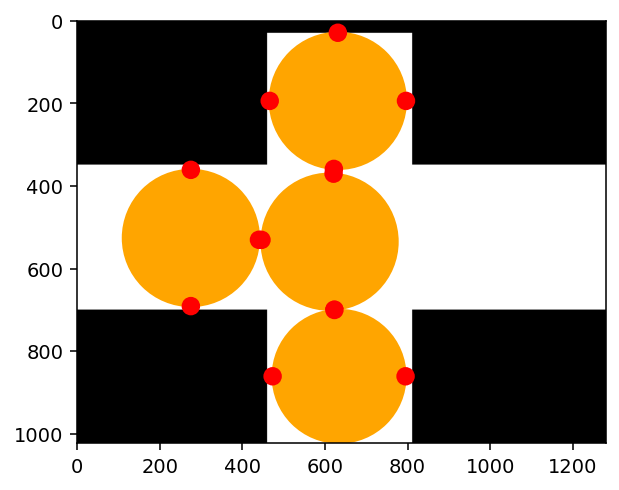

In [18]:
# Draw on all of the found contacts
fig, ax = plt.subplots()

ax.imshow(maskArr*255)

for i in range(len(centers)):
    # particle itself
    c = plt.Circle(centers[i][::-1], radii[i], label='Detected particle', color='orange')
    ax.add_artist(c)
    
    # Now add contacts
    for j in range(len(betaGuessArr[i])):
        contactPoint = centers[i] + radii[i] * np.array([np.cos(betaGuessArr[i][j]), np.sin(betaGuessArr[i][j])])
        #linePoints = np.array([centers[i], radii[i] * np.array([np.cos(betaGuessArr[i][j]), np.sin(betaGuessArr[i][j])])])
        #plt.plot(linePoints[0], linePoints[1], color='blue')
        cc = plt.Circle(contactPoint[::-1], 20, color='red')
        ax.add_artist(cc)
        
plt.show()

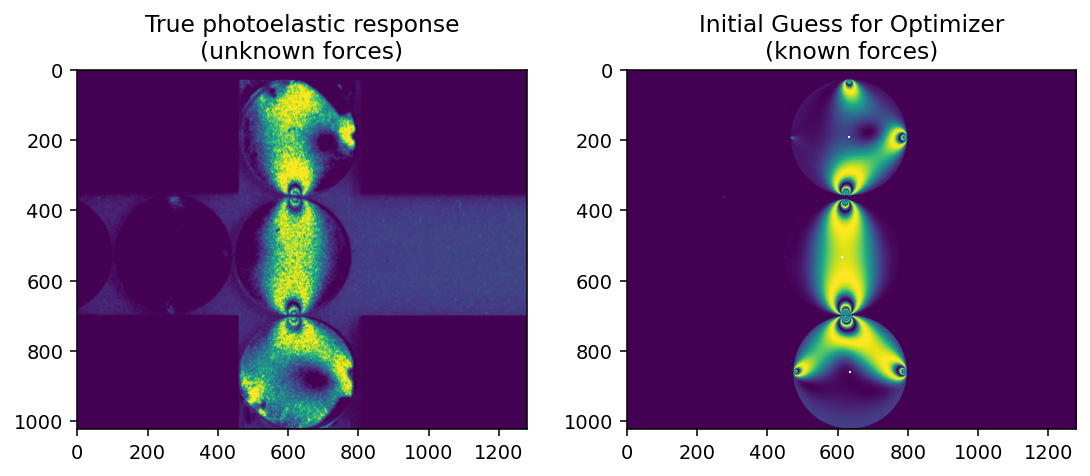

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(photoelasticChannel * maskArr[:,:,0])
ax[0].set_title('True photoelastic response\n(unknown forces)')

estimatedPhotoelasticChannel = np.zeros_like(photoelasticChannel, dtype=np.float64)

for i in range(len(centers)):
    estimatedPhotoelasticChannel += genSyntheticResponse(np.array(forceGuessArr[i]),
                                                         np.array(alphaGuessArr[i]),
                                                         np.array(betaGuessArr[i]),
                                                         fSigma, radii[i],
                                                         pxPerMeter, brightfield, imageSize=photoelasticChannel.shape,
                                                         center=centers[i])


ax[1].imshow(estimatedPhotoelasticChannel)
ax[1].set_title('Initial Guess for Optimizer\n(known forces)')

fig.tight_layout()
plt.show()

In [6]:
forceGuessArr

array([array([6.32016946e-05, 7.13591311e-04, 1.48527025e-04]),
       array([0.00015952, 0.08042421, 0.11596565]),
       array([0.10062547, 0.03421157, 0.0006903 , 0.07085352]),
       array([0.13965243, 0.02157687, 0.07988773])], dtype=object)